# Подключение необходимых библиотек

In [26]:

import copy
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torchvision import datasets, models, transforms
from torch.nn import functional as F
import torchinfo
from torchmetrics.classification import F1Score, Recall, Precision


# Считывание данных

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
num_epochs = 30
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

data = datasets.ImageFolder(root='./simpsons_dataset', transform=data_transforms['train'])
data_test = datasets.ImageFolder(root='./kaggle_simpson_testset', transform=data_transforms['test'])
generator = torch.Generator().manual_seed(42)
data_train, data_valid = torch.utils.data.random_split(data, [0.9, 0.1], generator=generator)
data_image = {
    'train':
        data_train,
    'validation':
        data_valid,
    'test':
        data_test
}

classes_image = {
    'train':
        list(data.class_to_idx.keys()),
    'test':
        list(data_test.class_to_idx.keys())
}

loaders_image = {
    'train':
        torch.utils.data.DataLoader(data_image['train'], batch_size=batch_size, shuffle=True),
    'validation':
        torch.utils.data.DataLoader(data_image['validation'], batch_size=batch_size, shuffle=True),
    'test':
        torch.utils.data.DataLoader(data_image['test'], batch_size=batch_size, shuffle=True)
}

# Визуализация картинок и их ключей

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


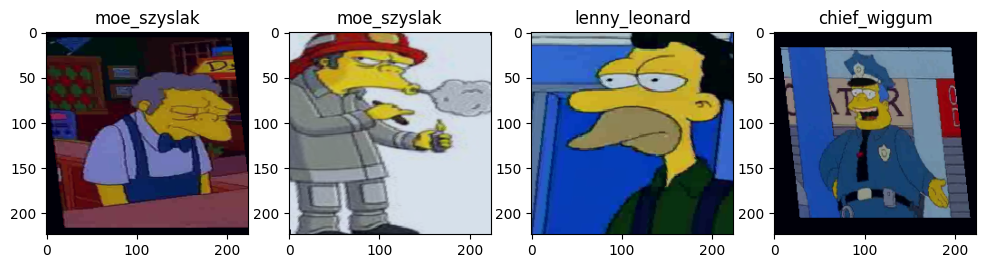

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


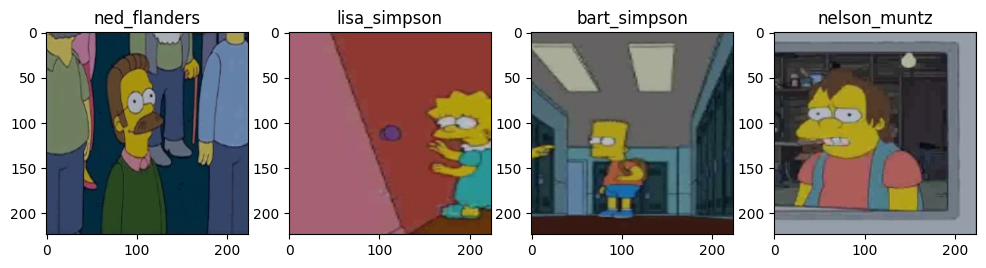

In [28]:

def image_shower(images, labels, phase, n=4):

    fig, axes = plt.subplots(1, 4)
    fig.set_figwidth(12)  # ширина и
    fig.set_figheight(6)
    for i, image in enumerate(images[:n]):
        image = image * 0.2 + 0.4
        print(image.size())
        axes[i].imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        axes[i].set_title(classes_image[phase][labels[i]])

    plt.show()
    

images, labels = next(iter(loaders_image['train']))
image_shower( images, labels, 'train')
images, labels = next(iter(loaders_image['test']))
image_shower( images, labels, 'test')

# Модель

In [29]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 42))
# model.fc = nn.Linear(512, 42)
model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr =0.001, momentum = 0.9)  
# scheduler = StepLR(optimizer, 
#                    step_size = 4, # Period of learning rate decay
#                    gamma = 0.5) # Multiplicative factor of learning rate decay
schedule = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 3, threshold = 0.01)
    
mcf1s = F1Score(task="multiclass", num_classes=42)
print(torchinfo.summary(model, input_size = (batch_size, 3, 224, 224)))

d:\Program Files (x86)\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program Files (x86)\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 42]                  --
├─Conv2d: 1-1                            [64, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        (128)
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [64, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]   

d:\Program Files (x86)\Python\Python310\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
d:\Program Files (x86)\Python\Python310\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


# Обучение

In [30]:
train_losses = []
valid_losses = []
num_epoch = 0
def train_model(model, criterion, optimizer):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders_image[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / len(data_image[phase])
            epoch_acc = running_corrects.double() / len(data_image[phase])
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                valid_losses.append(epoch_loss)
                if best_acc < epoch_acc: 
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    num_epoch = epoch
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    model.load_state_dict(best_model_wts)
    return model

train_model(model, criterion, optimizer)
print(num_epoch)


Epoch 1/30
----------
train loss: 3.0751, acc: 0.1433
validation loss: 2.8046, acc: 0.2809
Epoch 2/30
----------
train loss: 2.6262, acc: 0.3632
validation loss: 2.3674, acc: 0.4429
Epoch 3/30
----------
train loss: 2.2020, acc: 0.4988
validation loss: 1.9798, acc: 0.5523
Epoch 4/30
----------
train loss: 1.8606, acc: 0.5683
validation loss: 1.7242, acc: 0.6039
Epoch 5/30
----------
train loss: 1.6486, acc: 0.6111
validation loss: 1.5634, acc: 0.6221
Epoch 6/30
----------
train loss: 1.5078, acc: 0.6358
validation loss: 1.4439, acc: 0.6412
Epoch 7/30
----------
train loss: 1.4101, acc: 0.6519
validation loss: 1.3806, acc: 0.6636
Epoch 8/30
----------
train loss: 1.3371, acc: 0.6645
validation loss: 1.2973, acc: 0.6813
Epoch 9/30
----------
train loss: 1.2716, acc: 0.6790
validation loss: 1.2716, acc: 0.6928
Epoch 10/30
----------
train loss: 1.2344, acc: 0.6830
validation loss: 1.1967, acc: 0.6957
Epoch 11/30
----------
train loss: 1.1869, acc: 0.6909
validation loss: 1.1801, acc: 0.70

# График Loss

[3.075141407729714, 2.6261648632665096, 2.2020304481441553, 1.8606212172538612, 1.648559447357356, 1.5078231353415552, 1.410109871815724, 1.337065391884741, 1.271591656526942, 1.2343979199980475, 1.1868942596856702, 1.159668115420453, 1.124962814648946, 1.1065432887674644, 1.0694628773727741, 1.0567158885315977, 1.0261119338357525, 1.0081178976472016, 0.9969534703121063, 0.9698321124297545, 0.9690445650408476, 0.95042166254323, 0.9427398849444785, 0.9261369239499362, 0.9145098331627572, 0.8992033723559856, 0.8828488321314445, 0.881238567095147, 0.8710770980820788, 0.8615495113050862]
[2.8046014903551986, 2.367426253937103, 1.9798062295931922, 1.7242026506743817, 1.5633816446804625, 1.4438805060129216, 1.3806307471316794, 1.2972758481562907, 1.2715896438652399, 1.1967035604901595, 1.1800663549251893, 1.1498144065940774, 1.1396733039996296, 1.1029479133985969, 1.0820766363882073, 1.0840692648862573, 1.0395432154470463, 1.0373220505238263, 1.0214124682470196, 1.0191812731692282, 1.0145442

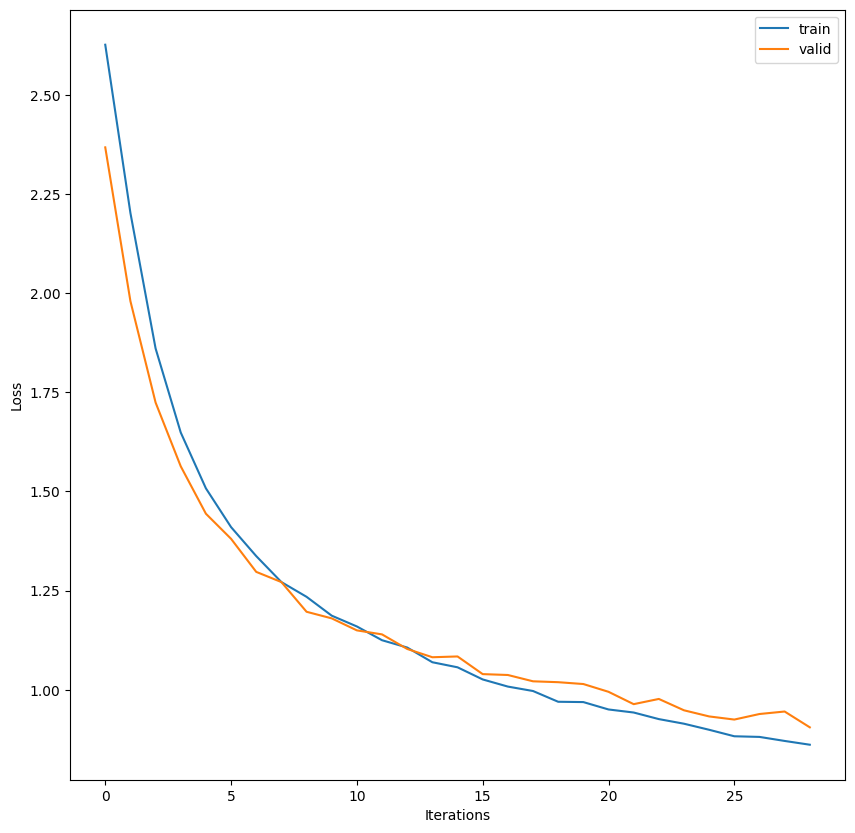

In [31]:
fig = plt.figure(figsize=(10, 10))

plt.plot(train_losses[1:], label='train')
plt.plot(valid_losses[1:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
print(train_losses)
print(valid_losses)


# Точность

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


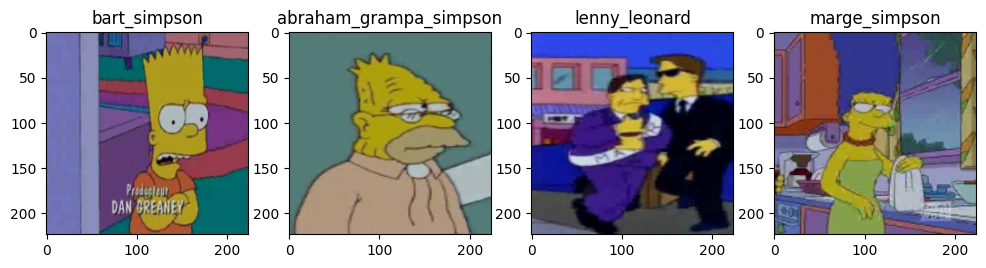

F1-score of the network on the 990 validation images: 73.1313 %


In [32]:
f1_score = F1Score(task = "multiclass", num_classes = 42)
with torch.no_grad():

    total = 0
    all_labels = []
    all_predicts = []

    for i, (images, labels) in enumerate(loaders_image['test']):
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        if not i:
            image_shower(images.cpu(), predicted.cpu(),'train')

        for a, res in enumerate(predicted):
            if classes_image['train'][res] == classes_image['test'][labels[a]]:
               predicted[a] = labels[a]

        all_labels = np.concatenate((all_labels, labels.cpu()), axis = 0)
        all_predicts = np.concatenate((all_predicts, predicted.cpu()), axis = 0)

        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    # print('Accuracy of the network on the {} validation images: {:.4f} %'.format(total, 100 * accuracy_score(all_labels, all_predicts)))
    # print('Precision of the network on the {} validation images: {:.4f} %'.format(total, 100 * precision_score(all_labels, all_predicts, average = 'weighted', zero_division = 0)))
    # print('Recall of the network on the {} validation images: {:.4f} %'.format(total, 100 * recall_score(all_labels, all_predicts, average = 'weighted', zero_division = 0)))
    print('F1-score of the network on the {} validation images: {:.4f} %'.format(total, 100 * f1_score(torch.tensor(all_predicts), torch.tensor(all_labels))))
